In [7]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
from imblearn.under_sampling import TomekLinks
import matplotlib.pyplot as plt
import seaborn as sns
# 맑은 고딕 폰트 설정 (Windows 환경)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

## 데이터 전처리

In [87]:
df1 = pd.read_csv('C:\\Users\\campus4D028\\Desktop\\국토안전관리원_빅데이터를 활용한 AI 기반 건설현장 점검 대상 선정 데이터셋_20211130.csv', encoding = 'cp949')
df2 = pd.read_csv('C:\\Users\\campus4D028\\Desktop\\국토안전관리원_건설안전사고사례_20240630.csv', encoding = 'cp949')
df3 = pd.read_csv('C:\\Users\\campus4D028\\Desktop\\국토안전관리원_시설물사고사례 위험요소별위험성_20171019..csv', encoding = 'cp949')
df4 = pd.read_csv('C:\\Users\\campus4D028\\Desktop\\국토안전관리원_건설안전사고 발생현황_재해자특성_20240331.csv', encoding = 'cp949')
df5 = pd.read_csv('C:\\Users\\campus4D028\\Desktop\\국토안전관리원_위험요소프로파일_사고_20230921.csv', encoding = 'cp949')
df6 = pd.read_csv('C:\\Users\\campus4D028\\Desktop\\건설현장_소재비별_건설사고_신고건수_및_인명피해_현황_신고사유별.csv', encoding = 'cp949')
df7 = pd.read_csv('C:\\Users\\campus4D028\\Desktop\\건설공사대장.csv', encoding = 'utf-8')

In [3]:
df1 = df1.dropna(subset=['건설업체소재지'])

In [4]:
df2 = df2.drop(columns = ['사고명', '연면적', '지상층수', '지하층수',
       '안전방호조치여부', '개인보호조치여부', '물적사고종류',  '사고위치 장소', '사고위치 장소(직접입력)', '사고위치 부위',
       '사고위치 부위(직접입력)', '사고원인(보조원인1)',
       '사고원인(보조원인2)', '구체적사고원인',
       '피해내용', 
       '향후조치계획', '사고경위', '사고발생후 조치사항', '재발방지대책'])

In [88]:
# '시설물 대분류'가 '건축' 또는 '토목'인 행만 선택
df2 = df2[df2['시설물 대분류'].isin(['건축', '토목'])]

# '시설물 중분류'에서 '미입력'과 '기타' 행 삭제
df2 = df2[~df2['시설물 중분류'].isin(['미입력', '기타'])]

# '인적사고종류(대분류)'에서 '미입력'과 '없음' 행 삭제
df2 = df2[~df2['인적사고종류(대분류)'].isin(['미입력', '없음'])]

# '작업프로세스'에서 결측치 행 삭제
df2 = df2[df2['작업프로세스'].notna()]

# '공사비'에서 '분류불능' 행 삭제
df2 = df2[df2['공사비'] != '분류불능']

# '공공민간구분'에서 '미입력' 행 삭제
df2 = df2[df2['공공민간구분'] != '미입력']

# '온도'에서 이상치 삭제
df2 = df2[(df2['온도'] > -40) & (df2['온도'] < 40) & df2['온도'].notna()]

In [89]:
# '공사시작일'과 '공사종료일'을 datetime 형식으로 변환
df2['공사시작일'] = pd.to_datetime(df2['공사시작일'], format='%Y-%m-%d')
df2['공사종료일'] = pd.to_datetime(df2['공사종료일'], format='%Y-%m-%d')

# 공사기간 계산 (일 단위)
df2['공사기간'] = (df2['공사종료일'] - df2['공사시작일']).dt.days

In [90]:
# '공사시작일'과 '공사종료일'을 datetime 형식으로 변환
df2['공사시작일'] = pd.to_datetime(df2['공사시작일'], format='%Y-%m-%d')
df2['공사종료일'] = pd.to_datetime(df2['공사종료일'], format='%Y-%m-%d')
df2['해당공종 공사시작일'] = pd.to_datetime(df2['해당공종 공사시작일'], format='%Y-%m-%d')
df2['해당공종 공사종료일'] = pd.to_datetime(df2['해당공종 공사종료일'], format='%Y-%m-%d')

# 공사기간 계산 (일 단위)
df2['공사기간'] = (df2['공사종료일'] - df2['공사시작일']).dt.days
df2['해당공종 공사기간'] = (df2['해당공종 공사종료일'] - df2['해당공종 공사시작일']).dt.days

In [91]:
# '공사기간'과 '해당공종 공사기간'이 음수인 행 삭제
df2 = df2[(df2['공사기간'] >= 0) & (df2['해당공종 공사기간'] >= 0)]

## 데이터 분석

## 건축이면서 공종소분류 top 5 사고발생유형
- 사망자가 발생했을경우에도 출력함
- 철근콘크리트에서 부상자와 사망자가 압도적임을 확인

In [10]:
# 앞글자 두 개에 따라 값 대체 및 나머지 삭제
def categorize_공사종류(종류):
    if 종류.startswith('건축'):
        return '건축'
    elif 종류.startswith('토목'):
        return '토목'
    else:
        return None

# '공사종류' 열의 값에 따라 대체
df4['공사종류'] = df4['공사종류'].apply(categorize_공사종류)

# '공사종류'가 NaN이 아닌 행만 필터링 (즉, '건축' 또는 '토목'으로 대체된 행만 유지)
df4 = df4.dropna(subset=['공사종류'])

In [11]:
df4 = df4.drop(columns = ['사고신고사유', '사고일시', '공정율', '날씨', '지역',  '공사비', 
       '내국인 사망자', '외국인 사망자', '남성 사망자', '여성 사망자', '10이상~20미만 사망자',
       '20이상~30미만 사망자', '30이상~40미만 사망자', '40이상~50미만 사망자', '50이상~60미만 사망자',
       '60이상 사망자', '내국인 부상자', '외국인 부상자', '남성 부상자', '여성 부상자',
       '10이상~20미만 부상자', '20이상~30미만 부상자', '30이상~40미만 부상자', '40이상~50미만 부상자',
       '50이상~60미만 부상자', '60이상 부상자'])

C:\Users\campus4D028\AppData\Local\Temp\ipykernel_16128\2917051849.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_5_공종소분류_all.index, y=top_5_공종소분류_all.values, palette='viridis', ax=axes[0])
C:\Users\campus4D028\AppData\Local\Temp\ipykernel_16128\2917051849.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_5_공종소분류_safety.index, y=top_5_공종소분류_safety.values, palette='viridis', ax=axes[1])


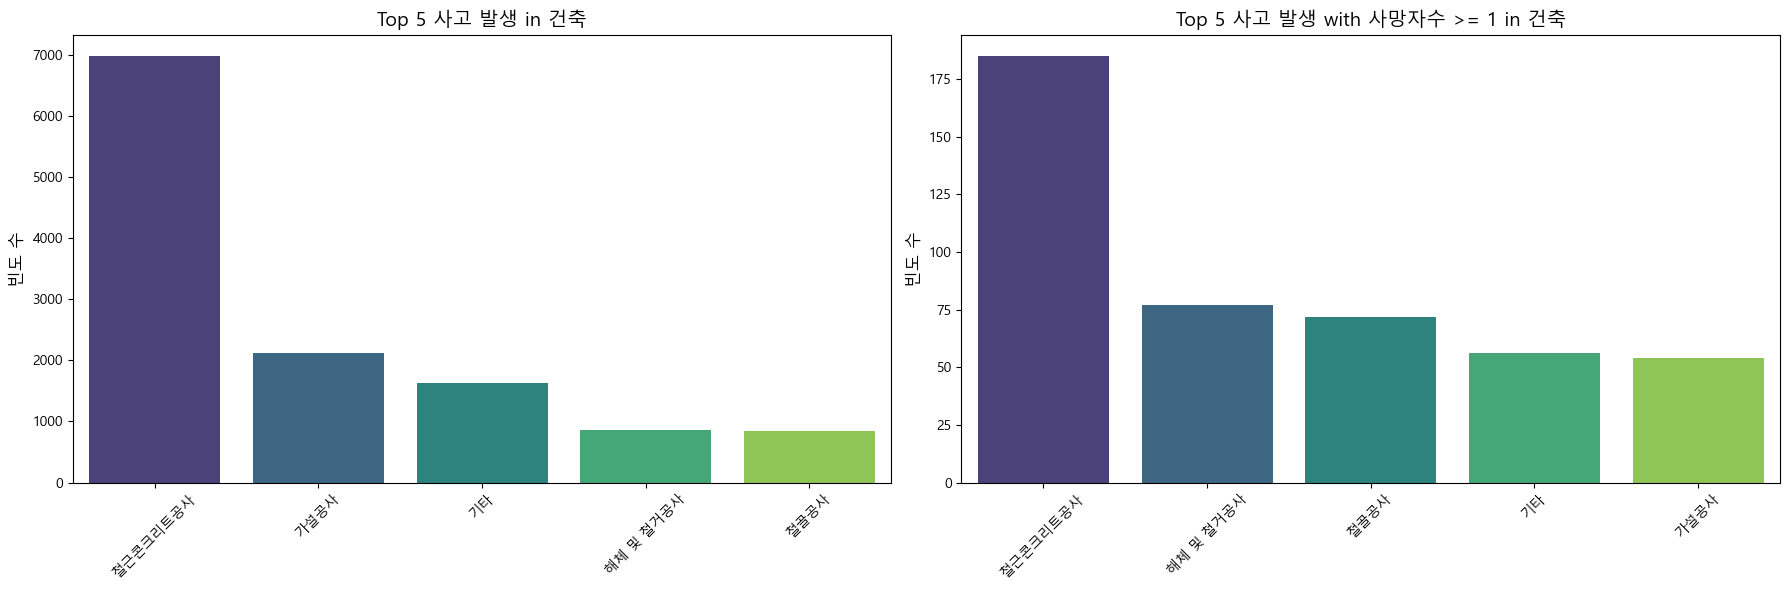

In [12]:
# '공사종류'가 '건축'인 데이터에서 '공종소분류'의 value_counts() 상위 5개 추출
top_5_공종소분류_all = df4[df4['공사종류'] == '건축']['공종소분류'].value_counts().head(5)

# '공사종류'가 '건축'이고 '사망자수'가 1 이상인 데이터만 필터링
건축_사망자_df = df4[(df4['공사종류'] == '건축') & (df4['사망자'] >= 1)]

# '공종소분류' 칼럼의 value_counts() 상위 5개 추출
top_5_공종소분류_safety = 건축_사망자_df['공종소분류'].value_counts().head(5)

# 시각화 준비
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 전체 데이터 시각화
sns.barplot(x=top_5_공종소분류_all.index, y=top_5_공종소분류_all.values, palette='viridis', ax=axes[0])
axes[0].set_title('Top 5 사고 발생 in 건축', fontsize=14)
axes[0].set_xlabel('', fontsize=12)
axes[0].set_ylabel('빈도 수', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# 사망자수 1 이상 데이터 시각화
sns.barplot(x=top_5_공종소분류_safety.index, y=top_5_공종소분류_safety.values, palette='viridis', ax=axes[1])
axes[1].set_title('Top 5 사고 발생 with 사망자수 >= 1 in 건축', fontsize=14)
axes[1].set_xlabel('', fontsize=12)
axes[1].set_ylabel('빈도 수', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

# 시각화 표시
plt.tight_layout()
plt.show()

## 토목이면서 공종소분류 top 5 사고발생유형
- 사망자가 발생했을경우에도 출력함
- 철근콘크리트공사 부상자가 많지만 사망자수집계에는 잡히지않음

C:\Users\campus4D028\AppData\Local\Temp\ipykernel_16128\1640550108.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_5_공종소분류_all.index, y=top_5_공종소분류_all.values, palette='viridis', ax=axes[0])
C:\Users\campus4D028\AppData\Local\Temp\ipykernel_16128\1640550108.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_5_공종소분류_safety.index, y=top_5_공종소분류_safety.values, palette='viridis', ax=axes[1])


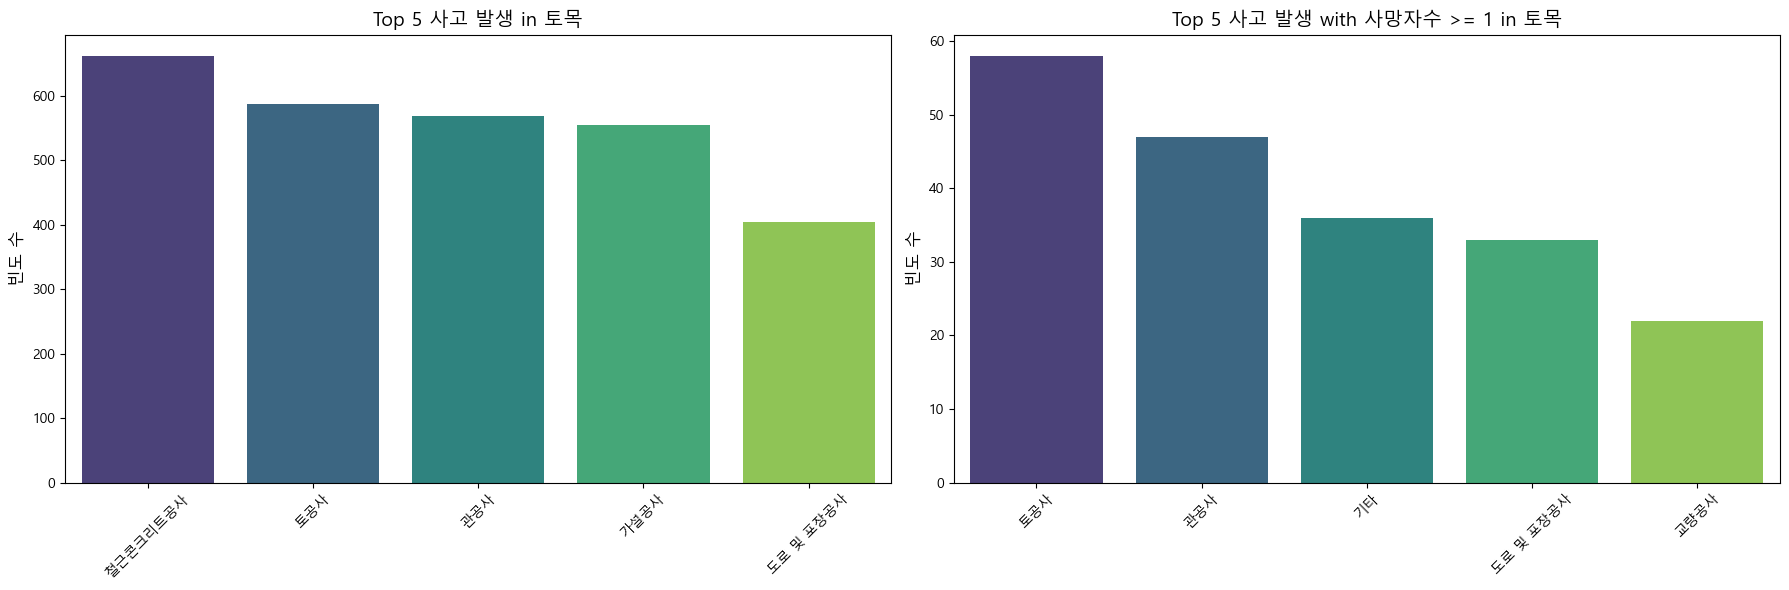

In [13]:
# '공사종류'가 '토목'인 데이터에서 '공종소분류'의 value_counts() 상위 5개 추출
top_5_공종소분류_all = df4[df4['공사종류'] == '토목']['공종소분류'].value_counts().head(5)

# '공사종류'가 '토목'이고 '사망자수'가 1 이상인 데이터만 필터링
토목_사망자_df = df4[(df4['공사종류'] == '토목') & (df4['사망자'] >= 1)]

# '공종소분류' 칼럼의 value_counts() 상위 5개 추출
top_5_공종소분류_safety = 토목_사망자_df['공종소분류'].value_counts().head(5)

# 시각화 준비
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 전체 데이터 시각화
sns.barplot(x=top_5_공종소분류_all.index, y=top_5_공종소분류_all.values, palette='viridis', ax=axes[0])
axes[0].set_title('Top 5 사고 발생 in 토목', fontsize=14)
axes[0].set_xlabel('', fontsize=12)
axes[0].set_ylabel('빈도 수', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# 사망자수 1 이상 데이터 시각화
sns.barplot(x=top_5_공종소분류_safety.index, y=top_5_공종소분류_safety.values, palette='viridis', ax=axes[1])
axes[1].set_title('Top 5 사고 발생 with 사망자수 >= 1 in 토목', fontsize=14)
axes[1].set_xlabel('', fontsize=12)
axes[1].set_ylabel('빈도 수', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

# 시각화 표시
plt.tight_layout()
plt.show()

## 작업자수 count
- 19인 이하에서 사고 발생 건수가 가장 많음

C:\Users\campus4D028\AppData\Local\Temp\ipykernel_16128\156555888.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=작업자수_counts.index, y=작업자수_counts.values, palette='viridis')


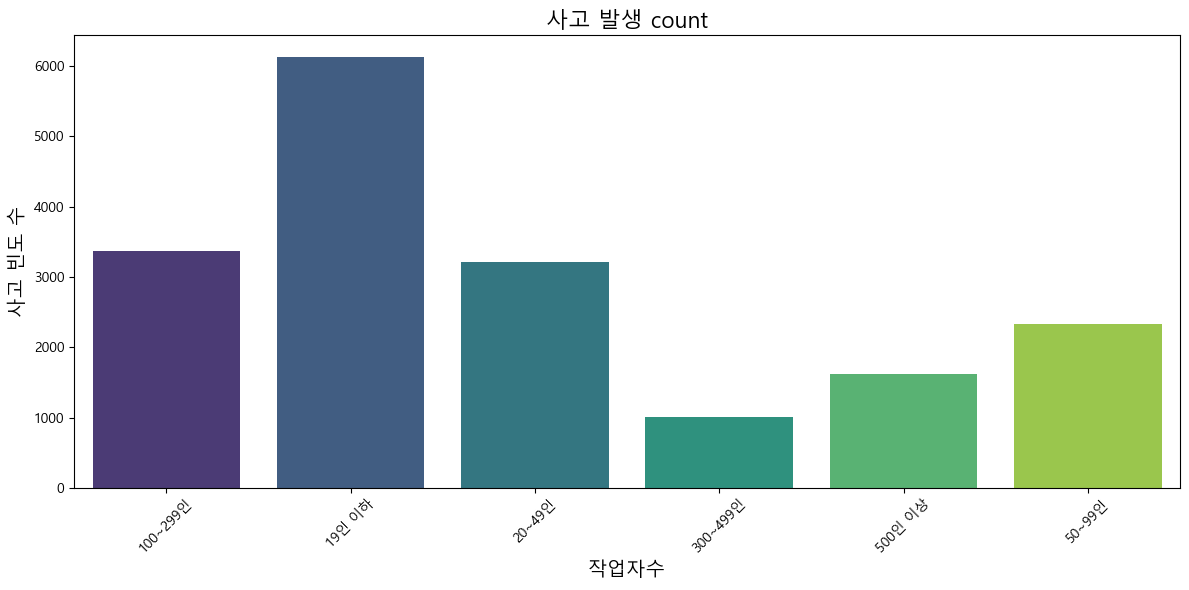

In [15]:
# '작업자수'의 빈도수 계산
작업자수_counts = df2['작업자수'].value_counts().sort_index()

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x=작업자수_counts.index, y=작업자수_counts.values, palette='viridis')

# 그래프 제목 및 레이블 설정
plt.title('사고 발생 count', fontsize=16)
plt.xlabel('작업자수', fontsize=14)
plt.ylabel('사고 빈도 수', fontsize=14)
plt.xticks(rotation=45)  # x축 레이블 회전

# 시각화 표시
plt.tight_layout()
plt.show()

## 공사기간 범주에 따른 count

공사기간_범주
1~3년     8835
1년 이내    3714
3년 이상    2913
Name: count, dtype: int64


C:\Users\campus4D028\AppData\Local\Temp\ipykernel_16128\2943797441.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df2, x='공사기간_범주', palette='viridis')


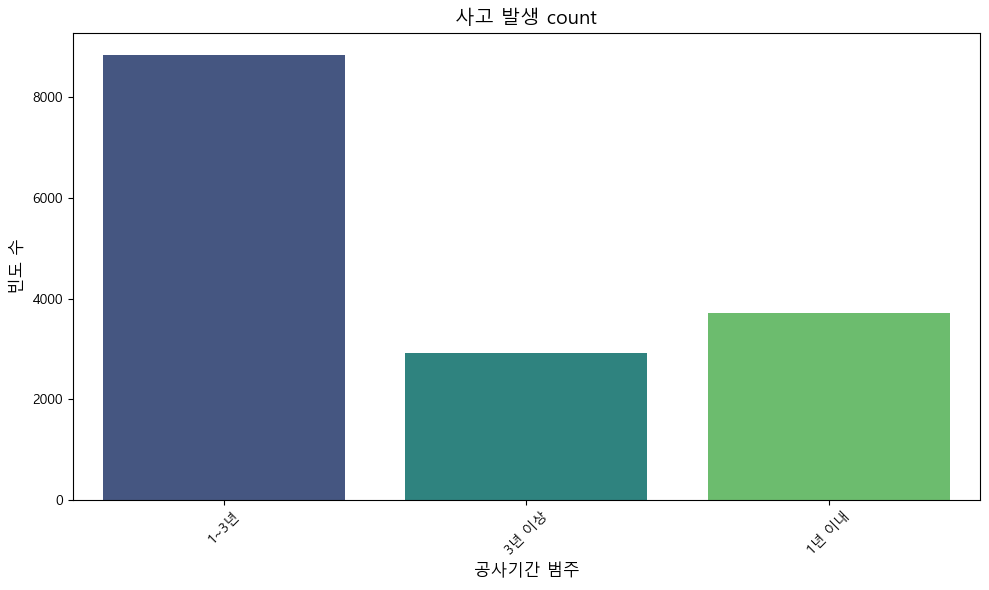

In [24]:
# 공사기간을 기준으로 범주화
def categorize_duration(duration):
    if duration <= 365:
        return '1년 이내'
    elif 366 <= duration <= 1095:
        return '1~3년'
    else:
        return '3년 이상'

# '공사기간' 칼럼에 대해 범주화 적용
df2['공사기간_범주'] = df2['공사기간'].apply(categorize_duration)

# 결과 확인
print(df2['공사기간_범주'].value_counts())

# 시각화 준비
plt.figure(figsize=(10, 6))
sns.countplot(data=df2, x='공사기간_범주', palette='viridis')

# 그래프 제목 및 레이블 설정
plt.title('사고 발생 count', fontsize=14)
plt.xlabel('공사기간 범주', fontsize=12)
plt.ylabel('빈도 수', fontsize=12)
plt.xticks(rotation=45)  # x축 레이블 회전

# 시각화 표시
plt.tight_layout()
plt.show()

## 공정율 범주별 빈도 수

C:\Users\campus4D028\AppData\Local\Temp\ipykernel_16128\2154096233.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')


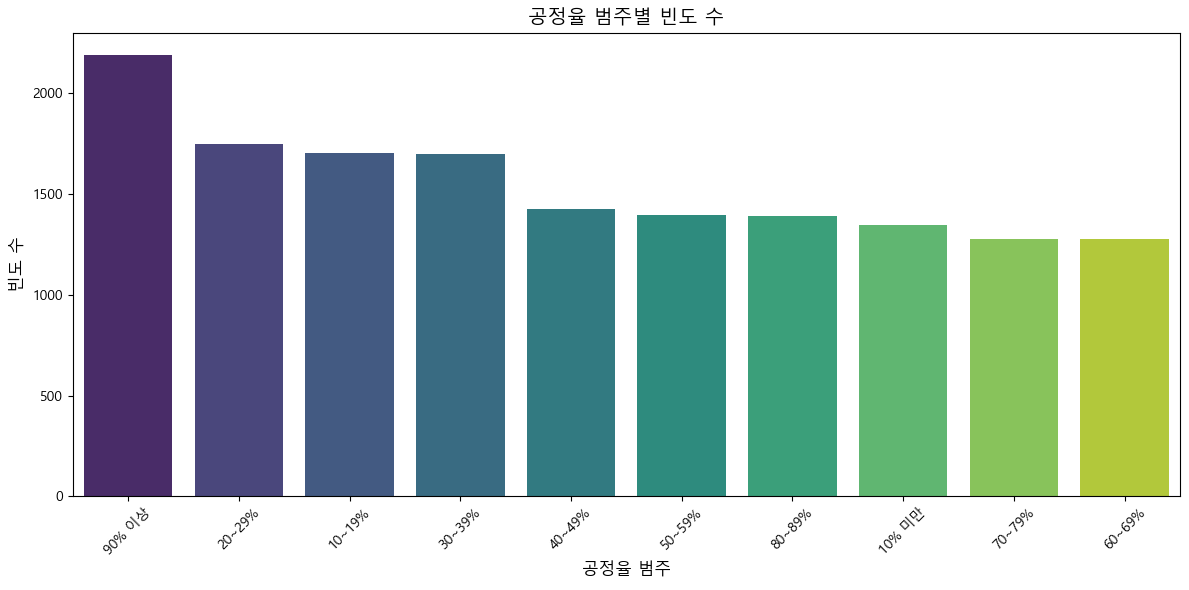

In [26]:
# 공정율의 value_counts() 계산
value_counts = df2['공정율'].value_counts()

# 시각화 준비
plt.figure(figsize=(12, 6))
sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')

# 그래프 제목 및 레이블 설정
plt.title('공정율 범주별 빈도 수', fontsize=14)
plt.xlabel('공정율 범주', fontsize=12)
plt.ylabel('빈도 수', fontsize=12)
plt.xticks(rotation=45)  # x축 레이블 회전

# 시각화 표시
plt.tight_layout()
plt.show()

## 진행중인 공사 내에 두번이상 사고가 발생한 건수
- 이런 행들의 특징은?

In [28]:
# 공사시작일과 공사종료일이 동일한 행을 그룹화하여 개수를 세기
grouped = df2.groupby(['공사시작일', '공사종료일']).size().reset_index(name='Count')

# count가 2인 이상인 그룹만 추출
df2_groups = grouped[grouped['Count'] >= 2]

# count가 5 이상인 그룹만 추출
df4_groups = grouped[grouped['Count'] >= 4]

# 원본 데이터프레임에서 count가 2 이상인 그룹의 모든 칼럼을 포함한 행만 추출
df2_groups = df2.merge(df2_groups[['공사시작일', '공사종료일']], on=['공사시작일', '공사종료일'])

# 원본 데이터프레임에서 count가 4 이상인 그룹의 모든 칼럼을 포함한 행만 추출
df4_groups = df2.merge(df4_groups[['공사시작일', '공사종료일']], on=['공사시작일', '공사종료일'])

In [29]:
len(df2_groups)

7839

In [30]:
len(df4_groups)

3827

In [31]:
df4_groups['시설물 대분류'].value_counts()

시설물 대분류
건축    3523
토목     304
Name: count, dtype: int64

## 동일한 공사중에 사고가 굉장히 자주 발생하는 공사(4건이상)에서 건축이 압도적으로 발생하는 것을 발견할 수 있음

C:\Users\campus4D028\AppData\Local\Temp\ipykernel_16128\3758864801.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')


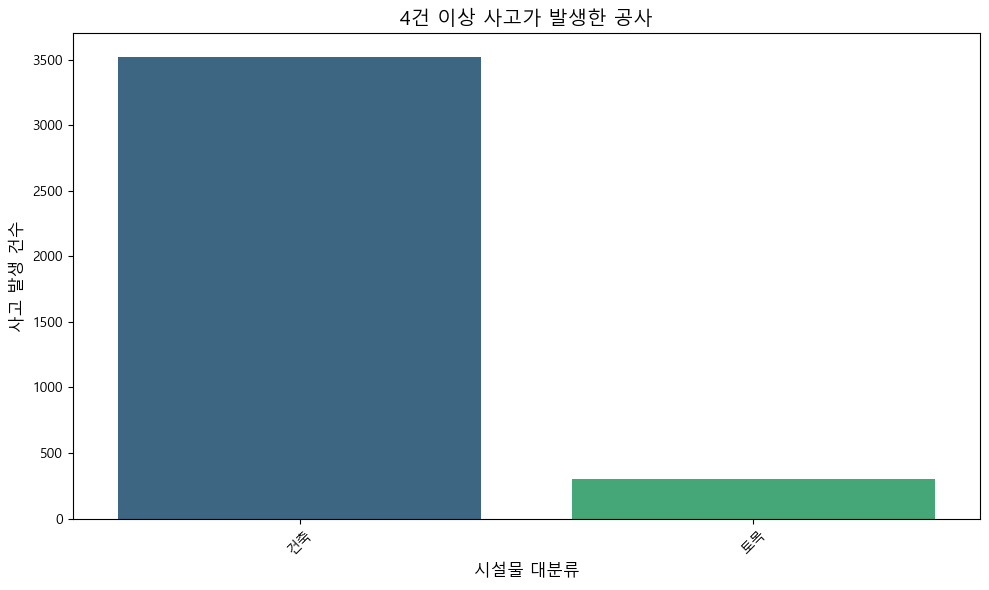

In [32]:
# '시설물 대분류'의 value_counts() 계산
value_counts = df4_groups['시설물 대분류'].value_counts()

# 시각화 준비
plt.figure(figsize=(10, 6))
sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')

# 그래프 제목 및 레이블 설정
plt.title('4건 이상 사고가 발생한 공사', fontsize=14)
plt.xlabel('시설물 대분류', fontsize=12)
plt.ylabel('사고 발생 건수', fontsize=12)
plt.xticks(rotation=45)  # x축 레이블 회전

# 시각화 표시
plt.tight_layout()
plt.show()

T-statistic: -25.5194
P-value: 0.0000
건축과 토목 분야의 공사기간 평균에 통계적으로 유의미한 차이가 있습니다.


C:\Users\campus4D028\AppData\Local\Temp\ipykernel_16128\708230977.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='시설물 대분류', y='공사기간', data=df_filtered, palette='viridis')


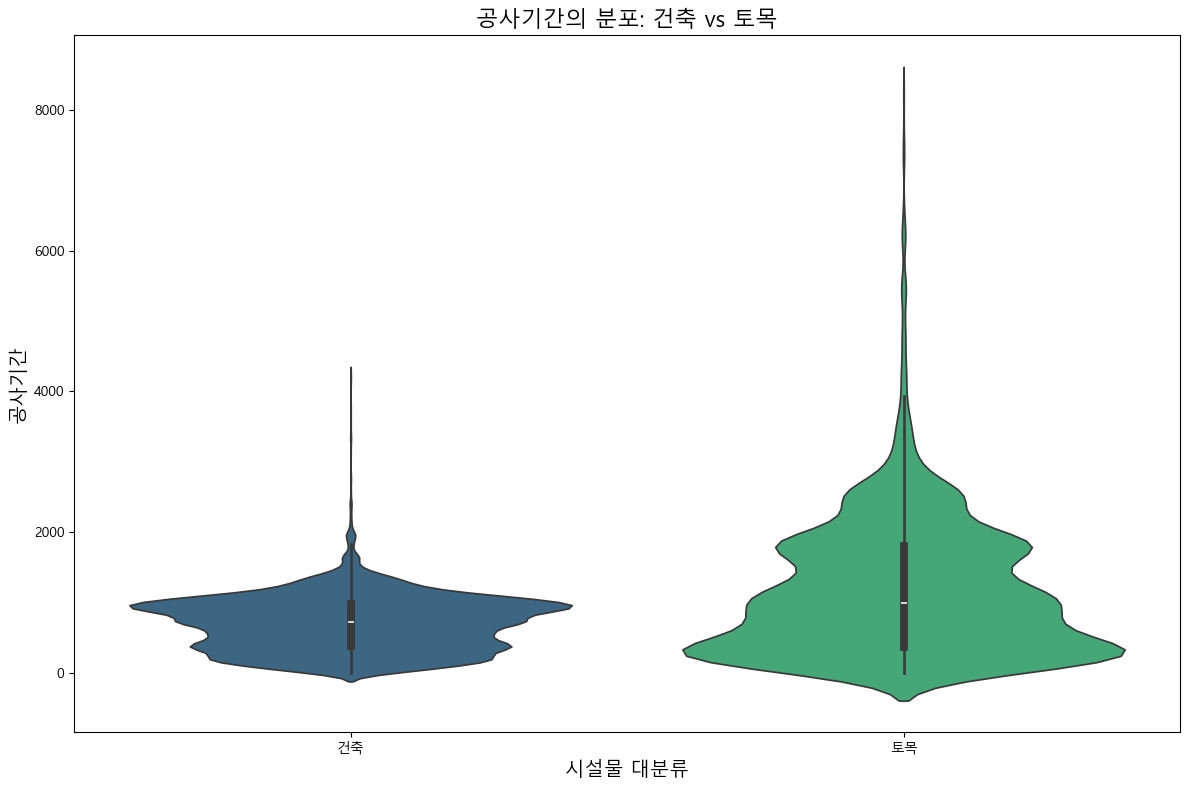

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
# '공사종류'가 '건축'인 데이터와 '토목'인 데이터로 필터링
건축_공사기간 = df2[df2['시설물 대분류'] == '건축']['공사기간']
토목_공사기간 = df2[df2['시설물 대분류'] == '토목']['공사기간']

# t-검정 수행
t_stat, p_value = ttest_ind(건축_공사기간.dropna(), 토목_공사기간.dropna(), equal_var=False)

# 결과 출력
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# 결과 해석
if p_value < 0.05:
    print("건축과 토목 분야의 공사기간 평균에 통계적으로 유의미한 차이가 있습니다.")
else:
    print("건축과 토목 분야의 공사기간 평균에 통계적으로 유의미한 차이가 없습니다.")

# 데이터프레임 준비 (violin plot을 위한 데이터 준비)
df_filtered = df2[df2['시설물 대분류'].isin(['건축', '토목'])]

# 시각화
plt.figure(figsize=(12, 8))
sns.violinplot(x='시설물 대분류', y='공사기간', data=df_filtered, palette='viridis')

# 그래프 제목 및 레이블 설정
plt.title('공사기간의 분포: 건축 vs 토목', fontsize=16)
plt.xlabel('시설물 대분류', fontsize=14)
plt.ylabel('공사기간', fontsize=14)

# 시각화 표시
plt.tight_layout()
plt.show()


## 공공/ 민간 기관에 따른 작업자수에 대한 분포

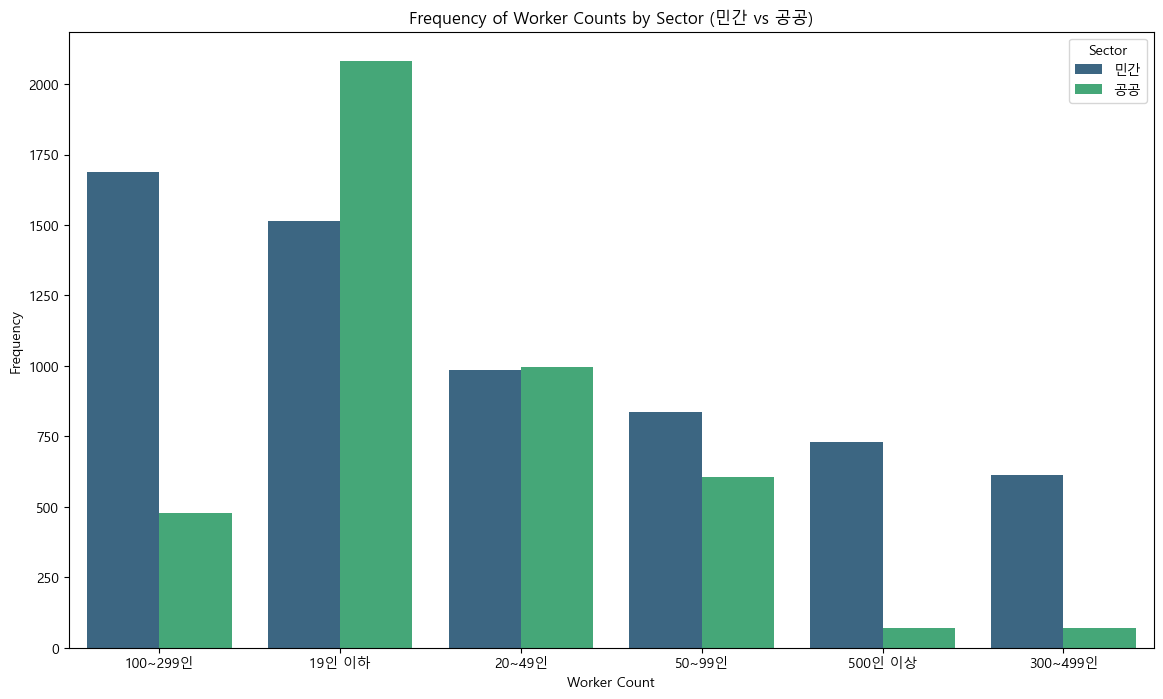

In [83]:
# 민간 데이터 필터링 및 빈도수 계산
cond_m = df2['공공민간구분'] == '민간'
df_m = df2.loc[cond_m]
worker_count_m = df_m['작업자수'].value_counts().reset_index()
worker_count_m.columns = ['Worker Count', 'Frequency']
worker_count_m['Sector'] = '민간'

# 공공 데이터 필터링 및 빈도수 계산
cond_p = df2['공공민간구분'] == '공공'
df_p = df2.loc[cond_p]
worker_count_p = df_p['작업자수'].value_counts().reset_index()
worker_count_p.columns = ['Worker Count', 'Frequency']
worker_count_p['Sector'] = '공공'

# 두 데이터프레임을 하나로 합치기
combined_df = pd.concat([worker_count_m, worker_count_p])

# 시각화
plt.figure(figsize=(14, 8))
sns.barplot(x='Worker Count', y='Frequency', hue='Sector', data=combined_df, palette='viridis')
plt.title('Frequency of Worker Counts by Sector (민간 vs 공공)')
plt.xlabel('Worker Count')
plt.ylabel('Frequency')
plt.xticks(rotation=360)  # x축 레이블을 45도 기울임
plt.legend(title='Sector')
plt.show()

## 인적사고 대분류

C:\Users\campus4D028\AppData\Local\Temp\ipykernel_16128\1000171867.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='사고원인-중분류', y='빈도수', data=acc_cause_subcat_count, palette='magma')


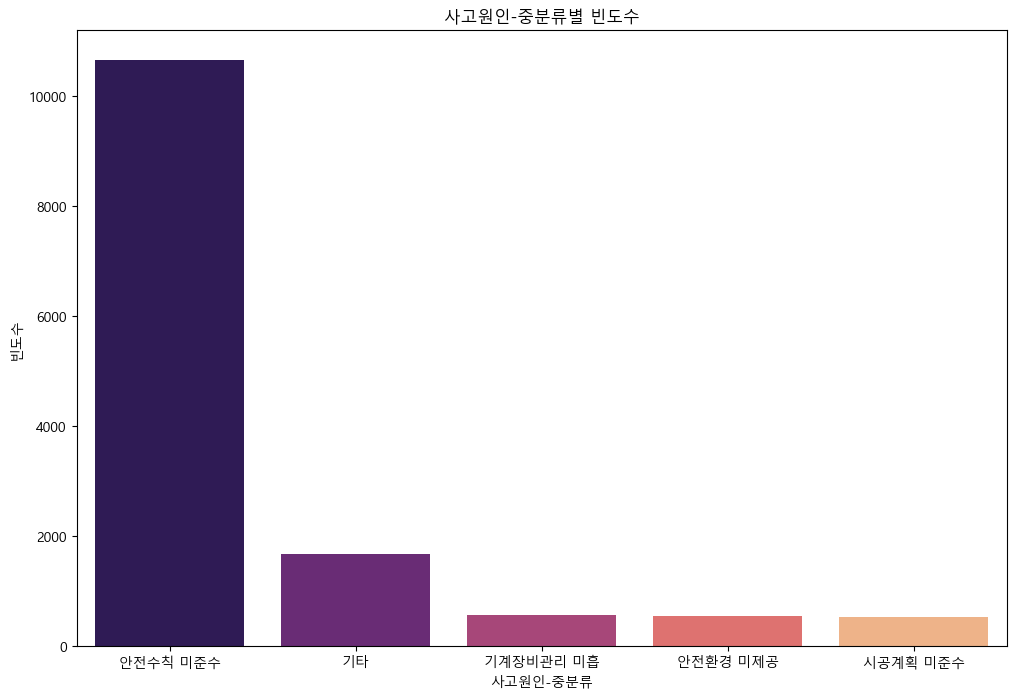

In [92]:
# 사고원인-중분류의 빈도수를 계산합니다.
acc_cause_subcat_count = df2['사고원인-중분류'].value_counts()

# 데이터프레임으로 변환합니다.
acc_cause_subcat_count = acc_cause_subcat_count.reset_index().head()
acc_cause_subcat_count.columns = ['사고원인-중분류', '빈도수']

# 그래프를 그립니다.
plt.figure(figsize=(12, 8))
sns.barplot(x='사고원인-중분류', y='빈도수', data=acc_cause_subcat_count, palette='magma')
plt.title('사고원인-중분류별 빈도수')
plt.xlabel('사고원인-중분류')
plt.ylabel('빈도수')
plt.show()

## 안전수칙과 인적사고에 차이가 있을까? (카이제곱 검정)

In [94]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# import scipy.stats as stats

# # 첫 번째 그룹: '안전수칙 미준수' 조건에 맞는 데이터
# cond2 = df2['사고원인-중분류'] == '안전수칙 미준수'
# df3 = df2.loc[cond1]

# # 두 번째 그룹: '안전수칙 미준수' 조건에 맞지 않는 데이터
# cond3 = df2['사고원인-중분류'] != '안전수칙 미준수'
# df4 = df2.loc[cond3]

# # 두 그룹의 '인적사고종류(대분류)' 빈도수 계산
# accident_type_counts2 = df3['인적사고종류(대분류)'].value_counts().sort_values(ascending=False).head(4)
# accident_type_counts3 = df4['인적사고종류(대분류)'].value_counts().reindex(accident_type_counts2.index).fillna(0)

# # 두 그룹의 빈도수를 하나의 데이터프레임으로 결합
# accident_type_df = pd.DataFrame({
#     '안전수칙 미준수': accident_type_counts2,
#     '안전수칙 준수': accident_type_counts3
# })

# # 막대그래프 시각화
# accident_type_df.plot(kind='bar', figsize=(14, 7), color=['skyblue', 'salmon'])
# plt.title('인적사고종류 안전 수칙 기준 분포 비교')
# plt.ylabel('빈도수')
# plt.xticks(rotation=360)
# plt.legend(title='그룹')
# plt.show()

# # 카이제곱 검정 수행
# chi2_stat, p_val, _, _ = stats.chi2_contingency(accident_type_df.T)

# print(f"Chi2 Stat: {chi2_stat}")
# print(f"P-Value: {p_val}")

# if p_val < 0.05:
#     print("유의미한 차이가 있습니다.")
# else:
#     print("유의미한 차이가 없습니다.")

## 공사비 1000억 기준 코드 및 시각화

In [95]:
# '공사범주'를 정의하는 함수를 만듭니다.
def categorize_construction_cost(cost):
    cost = str(cost)  # cost 값을 문자열로 변환합니다.
    if cost == '1억이하':  # '1억이하'는 명확히 2천만원 미만으로 가정
        return '1000억 미만'
    elif '10억초과 20억이하' in cost or '5억초과 10억이하' in cost or '1억초과 5억이하' in cost:
        return '1000억 미만'
    elif '20억초과 30억이하' in cost or '30억초과 40억이하' in cost or '40억초과 50억이하' in cost:
        return '1000억 미만'
    elif '50억초과 60억이하' in cost or '60억초과 70억이하' in cost or '70억초과 80억이하' in cost or '80억초과 90억이하' in cost or '90억초과 100억이하' in cost:
        return '1000억 미만'
    elif '100억초과 200억이하' in cost or '200억초과 300억이하' in cost or '300억초과 400억이하' in cost or '400억초과 500억이하' in cost or '500억초과 1000억이하' in cost:
        return '1000억 미만'
    elif '1000억초과 2000억이하' in cost or '2000억초과' in cost:
        return '1000억 이상'
    else:
        return '분류불능'  # 위 조건에 해당하지 않는 모든 경우를 '800억원 이상'으로 분류

# # 기존 데이터프레임에 '공사범주'라는 새로운 컬럼을 추가합니다.
# df1_clean['공사범주'] = df1_clean['공사비'].apply(categorize_construction_cost)

# # 결과 확인
# df1_clean[['공사비', '공사범주']].head()

# 기존 데이터프레임에 '공사범주'라는 새로운 컬럼을 추가합니다.
df1.loc[:, '공사비_구간_재조정'] = df1['공사비'].apply(categorize_construction_cost)


# 결과 확인
df1[['공사비', '공사비_구간_재조정']].head()


,공사비,공사비_구간_재조정
0,100억초과 200억이하,1000억 미만
1,100억초과 200억이하,1000억 미만
2,100억초과 200억이하,1000억 미만
3,100억초과 200억이하,1000억 미만
4,20억초과 30억이하,1000억 미만


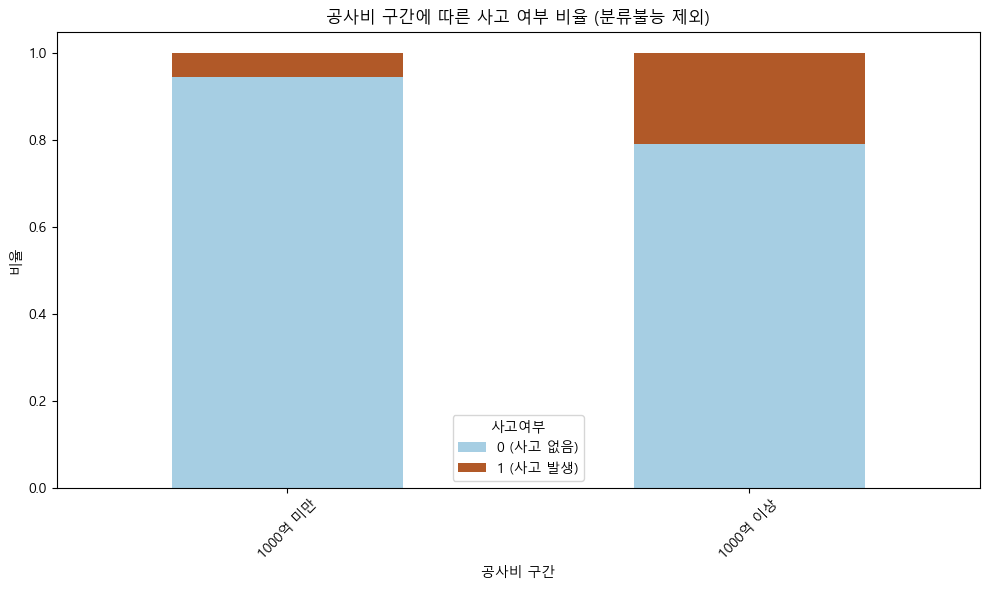

In [96]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

# 환경 설정
import matplotlib
# 한글 설치(윈도우 버전)
matplotlib.rc('font', family='Malgun Gothic')
# 음수 표시
matplotlib.rc('axes', unicode_minus=False)
# 그래프 출력
%matplotlib inline

# 실행결과 경고메시지 출력 제외
import warnings
warnings.filterwarnings('ignore')

# '분류불능' 데이터 제외
df_filtered = df1[df1['공사비_구간_재조정'] != '분류불능']

# 공사비 구간별 사고 여부에 따른 데이터 그룹핑
df_grouped_filtered = df_filtered.groupby(['공사비_구간_재조정', '사고여부']).size().unstack(fill_value=0)

# 사고여부 0과 1의 비율 계산
df_grouped_filtered = df_grouped_filtered.div(df_grouped_filtered.sum(axis=1), axis=0)

# 공사비 구간에 따른 사고 여부 비율 시각화
df_grouped_filtered.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Paired')

plt.title('공사비 구간에 따른 사고 여부 비율 (분류불능 제외)')
plt.xlabel('공사비 구간')
plt.ylabel('비율')
plt.xticks(rotation=45)
plt.legend(title='사고여부', labels=['0 (사고 없음)', '1 (사고 발생)'])
plt.tight_layout()
plt.show()


## 검정까지

In [97]:
import scipy.stats as stats

# 교차표 생성
contingency_table = pd.crosstab(df1['공사비_구간_재조정'], df1['사고여부'])

# '분류불능' 행 제거
contingency_table_cleaned = contingency_table.drop(index='분류불능')

# # 교차표 출력 확인
# print("Cleaned Contingency Table:")
# print(contingency_table_cleaned)

# 카이제곱 검정 실행
chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_table_cleaned)

print(f"Chi2 Stat: {chi2_stat}")
print(f"P-value: {p_val}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected Frequencies:\n{expected}")



Chi2 Stat: 438.1941833906145
P-value: 2.675859609916541e-97
Degrees of Freedom: 1
Expected Frequencies:
[[15067.03635838  1041.96364162]
 [ 1113.96364162    77.03635838]]


## 건축, 토목 구분해서 1000억 이상 이하

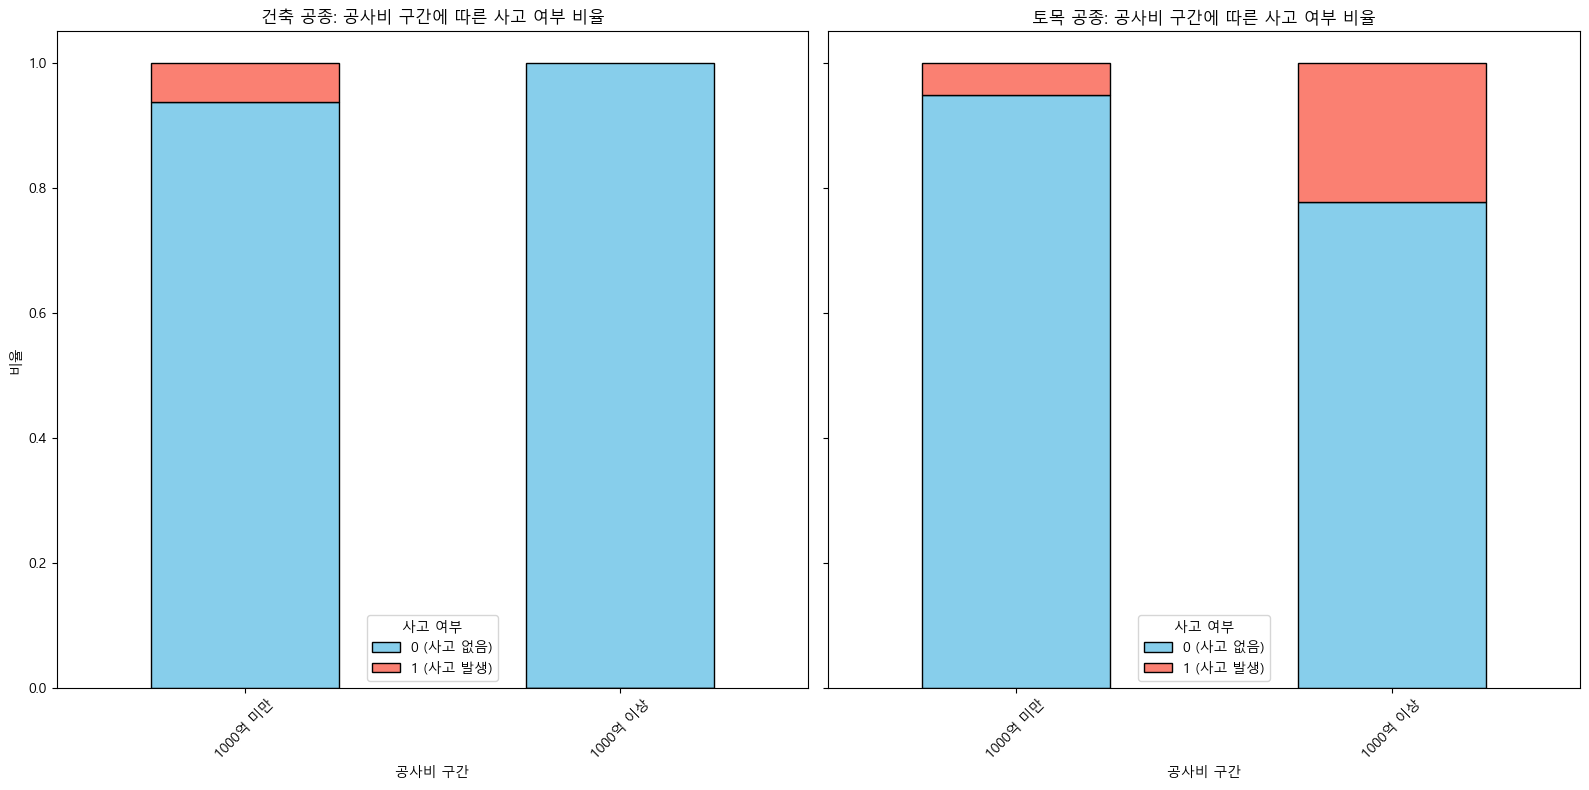

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 데이터 준비
df_grouped = df1.groupby(['공종', '공사비_구간_재조정', '사고여부']).size().unstack(fill_value=0)
df_grouped = df_grouped.div(df_grouped.sum(axis=1), axis=0).reset_index()  # 비율로 변환 및 리셋 인덱스
df_grouped = df_grouped.melt(id_vars=['공종', '공사비_구간_재조정'], var_name='사고여부', value_name='비율')


# '분류불능'을 제거
df_grouped = df_grouped[df_grouped['공사비_구간_재조정'] != '분류불능']


# 공종별로 데이터 필터링
df_building = df_grouped[df_grouped['공종'] == '건축']
df_civil = df_grouped[df_grouped['공종'] == '토목']



# 시각화
fig, axs = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# 건축 공종 시각화
df_building_pivot = df_building.pivot(index='공사비_구간_재조정', columns='사고여부', values='비율').fillna(0)
df_building_pivot.plot(kind='bar', stacked=True, ax=axs[0], color=['skyblue', 'salmon'], edgecolor='black')
axs[0].set_title('건축 공종: 공사비 구간에 따른 사고 여부 비율')
axs[0].set_xlabel('공사비 구간')
axs[0].set_ylabel('비율')
axs[0].legend(title='사고 여부', labels=['0 (사고 없음)', '1 (사고 발생)'])
axs[0].tick_params(axis='x', rotation=45)

# 토목 공종 시각화
df_civil_pivot = df_civil.pivot(index='공사비_구간_재조정', columns='사고여부', values='비율').fillna(0)
df_civil_pivot.plot(kind='bar', stacked=True, ax=axs[1], color=['skyblue', 'salmon'], edgecolor='black')
axs[1].set_title('토목 공종: 공사비 구간에 따른 사고 여부 비율')
axs[1].set_xlabel('공사비 구간')
axs[1].set_ylabel('비율')
axs[1].legend(title='사고 여부', labels=['0 (사고 없음)', '1 (사고 발생)'])
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## 건축과 토목 인적사고 종류

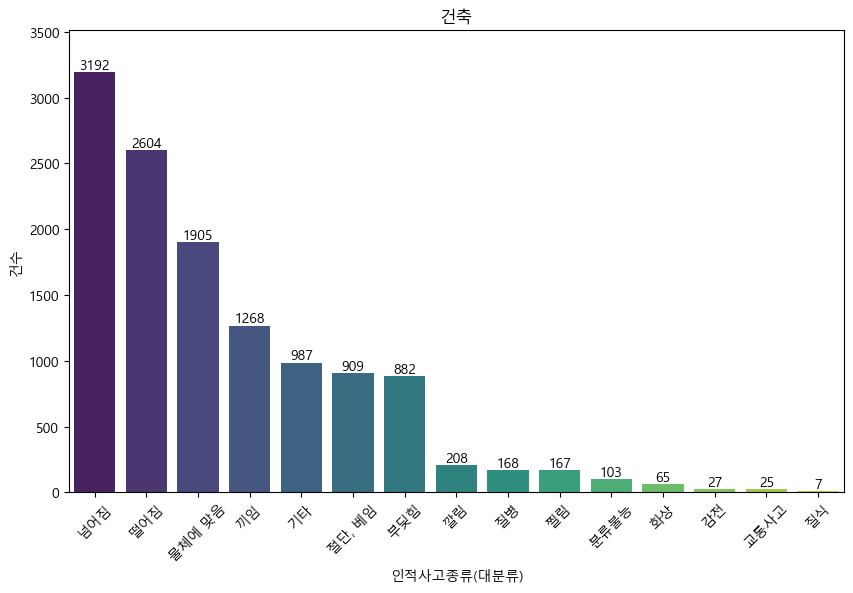

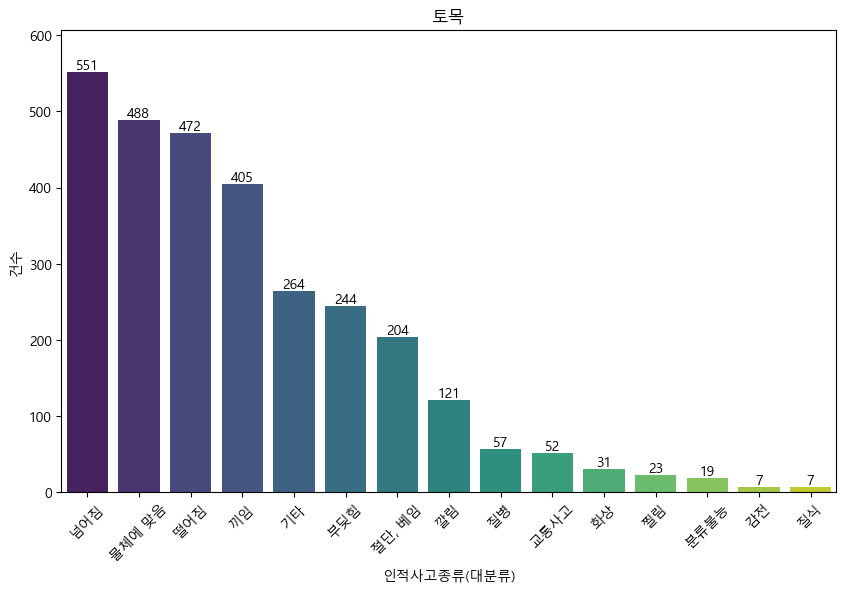

In [99]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 타입 확인 및 변환
df2['시설물 대분류'] = df2['시설물 대분류'].astype(str)
df2['인적사고종류(대분류)'] = df2['인적사고종류(대분류)'].astype(str)

# 건축과 토목으로 데이터 분리
df_building = df2[df2['시설물 대분류'] == '건축']
df_civil = df2[df2['시설물 대분류'] == '토목']

# 건축 데이터 시각화
plt.figure(figsize=(10, 6))
ax_building = plt.gca()

# 인적사고종류(대분류)의 빈도 수를 기준으로 정렬
order_building = df_building['인적사고종류(대분류)'].value_counts().index

sns.countplot(x='인적사고종류(대분류)', data=df_building, palette='viridis', ax=ax_building, order=order_building)
ax_building.set_title('건축')
ax_building.set_xlabel('인적사고종류(대분류)')
ax_building.set_ylabel('건수')
ax_building.tick_params(axis='x', rotation=45)

# 빈도 수치 추가
for p in ax_building.patches:
    height = p.get_height()
    ax_building.text(p.get_x() + p.get_width() / 2., height + 0.05, int(height), ha='center', va='bottom')

# y축 범위 조정
max_y_building = df_building['인적사고종류(대분류)'].value_counts().max()
ax_building.set_ylim(0, max_y_building + 0.1 * max_y_building)

plt.show()

# 토목 데이터 시각화
plt.figure(figsize=(10, 6))
ax_civil = plt.gca()

# 인적사고종류(대분류)의 빈도 수를 기준으로 정렬
order_civil = df_civil['인적사고종류(대분류)'].value_counts().index

sns.countplot(x='인적사고종류(대분류)', data=df_civil, palette='viridis', ax=ax_civil, order=order_civil)
ax_civil.set_title('토목')
ax_civil.set_xlabel('인적사고종류(대분류)')
ax_civil.set_ylabel('건수')
ax_civil.tick_params(axis='x', rotation=45)

# 빈도 수치 추가
for p in ax_civil.patches:
    height = p.get_height()
    ax_civil.text(p.get_x() + p.get_width() / 2., height + 0.05, int(height), ha='center', va='bottom')

# y축 범위 조정
max_y_civil = df_civil['인적사고종류(대분류)'].value_counts().max()
ax_civil.set_ylim(0, max_y_civil + 0.1 * max_y_civil)

plt.show()


## 인적사고 종류 월별 시각화

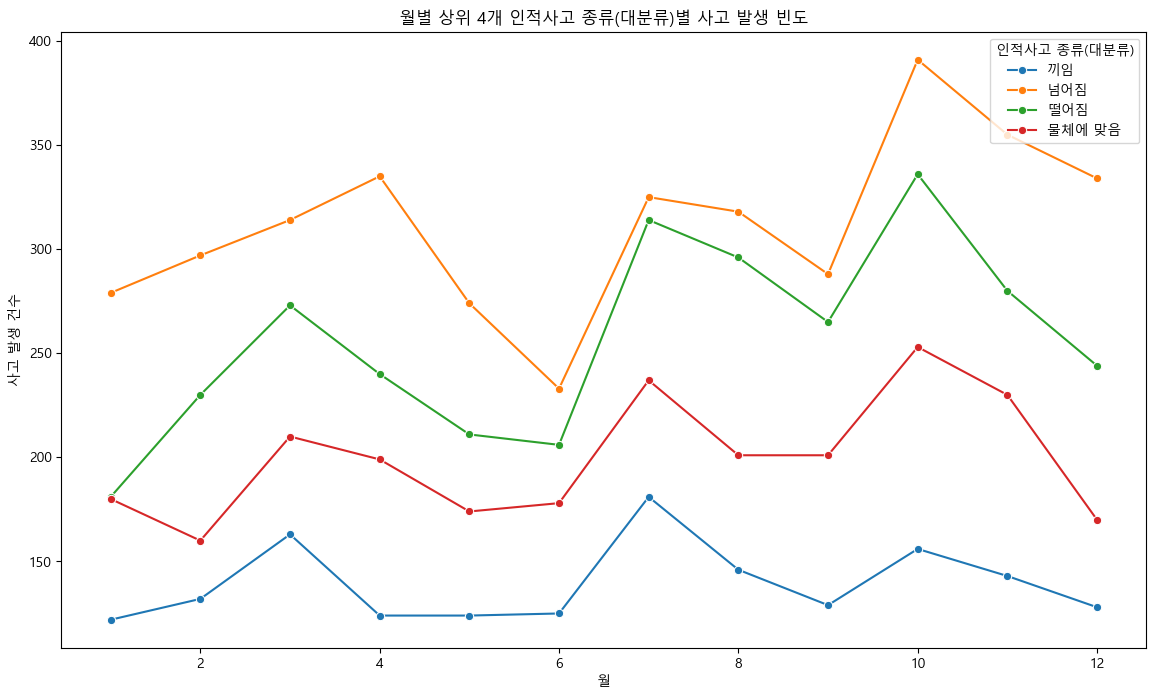

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 사고일시를 datetime 형식으로 변환
df2['사고일시'] = pd.to_datetime(df2['사고일시'])

# 월 파생변수 생성
df2['사고월'] = df2['사고일시'].dt.month

# 인적사고 종류(대분류)별 전체 사고 발생 건수 계산
total_accidents = df2['인적사고종류(대분류)'].value_counts()

# 상위 4개의 인적사고 종류(대분류) 선택
top_4_accidents = total_accidents.nlargest(4).index.tolist()

# 상위 4개의 사고 종류만 필터링
df_filtered = df2[df2['인적사고종류(대분류)'].isin(top_4_accidents)]

# 월별 상위 4개 인적사고 종류(대분류)별 사고 발생 빈도 계산
monthly_accidents_top4 = df_filtered.groupby(['사고월', '인적사고종류(대분류)']).size().reset_index(name='count')

# 선 그래프 그리기
plt.figure(figsize=(14, 8))
sns.lineplot(x='사고월', y='count', hue='인적사고종류(대분류)', data=monthly_accidents_top4, marker='o')

# 그래프 제목과 레이블 추가
plt.title('월별 상위 4개 인적사고 종류(대분류)별 사고 발생 빈도')
plt.xlabel('월')
plt.ylabel('사고 발생 건수')

# 범례 위치 조정
plt.legend(title='인적사고 종류(대분류)', loc='upper right')

# 그래프 표시
plt.show()


## 공종별 사고여부 카이스퀘어 검정 및 시각화

In [108]:
df1 = df1.dropna(subset=['건설업체소재지'])

In [109]:
import pandas as pd
import scipy.stats as stats
df1_clean=df1.drop(columns = ['일자', '낙찰율(퍼센트)', '총공사일수', '공사비'])
# '건축'과 '토목' 공종만 필터링
df_filtered = df1_clean[df1_clean['공종'].isin(['건축', '토목'])]

# 공종별 사고여부 교차표 생성
cross_tab = pd.crosstab(df_filtered['공종'], df_filtered['사고여부'])

# 교차표 출력
print("공종별 사고여부 교차표:")
print(cross_tab)

# 카이제곱 검정
chi2, p, dof, expected = stats.chi2_contingency(cross_tab)

print(f"\n카이제곱 통계량: {chi2}")
print(f"p-value: {p}")

if p < 0.05:
    print("공종별 사고여부에 유의미한 차이가 있습니다.")
else:
    print("공종별 사고여부에 유의미한 차이가 없습니다.")


공종별 사고여부 교차표:
사고여부      0    1
공종              
건축    38618  426
토목    26397  836

카이제곱 통계량: 335.2299985616453
p-value: 6.977717171418768e-75
공종별 사고여부에 유의미한 차이가 있습니다.


<Figure size 1000x600 with 0 Axes>

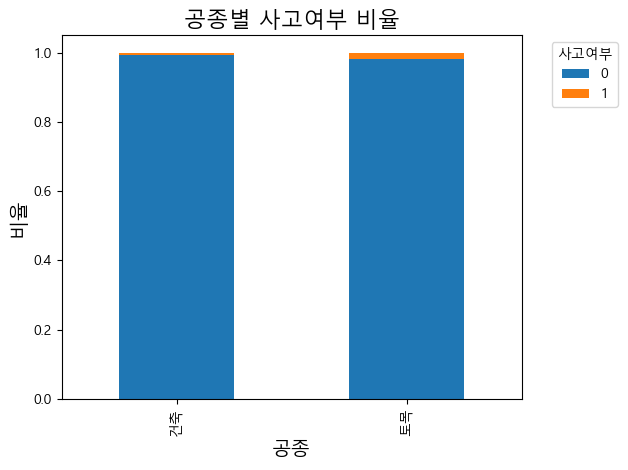

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

# 사고 여부를 비율로 계산하기 위해 cross_tab을 비율로 변환
cross_tab_ratio = cross_tab.div(cross_tab.sum(axis=1), axis=0)

# 시각화
plt.figure(figsize=(10, 6))
cross_tab_ratio.plot(kind='bar', stacked=True)

# 그래프 제목 및 축 레이블 설정
plt.title('공종별 사고여부 비율', fontsize=16)
plt.xlabel('공종', fontsize=14)
plt.ylabel('비율', fontsize=14)

# 범례 추가
plt.legend(title='사고여부', bbox_to_anchor=(1.05, 1), loc='upper left')

# 그래프 출력
plt.tight_layout()
plt.show()


## 건축과 토목 공종에 대한 보유기술자수 평균 차이 투샘플 티테스트 및 시각화

In [110]:
from scipy.stats import ttest_ind

# '건축'과 '토목' 공종에 대해 보유기술자수 평균 계산
architecture = df_filtered[df_filtered['공종'] == '건축']['보유기술자수 ']
civil = df_filtered[df_filtered['공종'] == '토목']['보유기술자수 ']

# 평균 출력
print(f"건축 공종 보유기술자수 평균: {architecture.mean()}")
print(f"토목 공종 보유기술자수 평균: {civil.mean()}")

# t-검정 수행
t_stat, p_val = ttest_ind(architecture, civil)

print(f"\nt-통계량: {t_stat}")
print(f"p-value: {p_val}")

if p_val < 0.05:
    print("공종별 보유기술자수 평균에 유의미한 차이가 있습니다.")
else:
    print("공종별 보유기술자수 평균에 유의미한 차이가 없습니다.")

건축 공종 보유기술자수 평균: 56.677466448109826
토목 공종 보유기술자수 평균: 79.92890977857746

t-통계량: -9.113003999225914
p-value: 8.229334393332044e-20
공종별 보유기술자수 평균에 유의미한 차이가 있습니다.


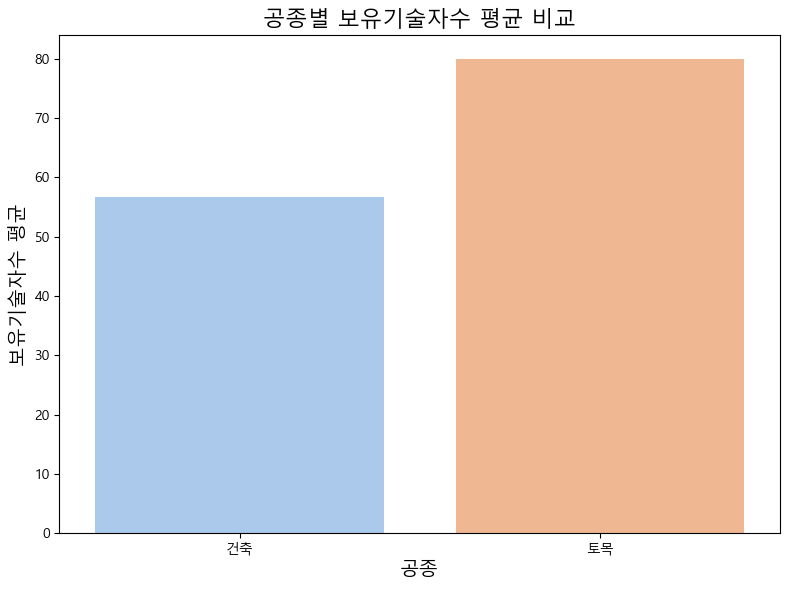

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

# 공종별 보유기술자수 평균 계산
means = df_filtered.groupby('공종')['보유기술자수 '].mean()

# 시각화
plt.figure(figsize=(8, 6))
sns.barplot(x=means.index, y=means.values, palette="pastel")

# 그래프 제목 및 축 레이블 설정
plt.title('공종별 보유기술자수 평균 비교', fontsize=16)
plt.xlabel('공종', fontsize=14)
plt.ylabel('보유기술자수 평균', fontsize=14)

# 그래프 출력
plt.tight_layout()
plt.show()


## 모델링1
- 사고여부 예측 머신러닝

In [37]:
df1['사고여부'].value_counts()

사고여부
0    65015
1     1262
Name: count, dtype: int64

## 범주형 변수 라벨인코딩 후 로지스틱 회귀

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# 라벨 인코딩
label_encoder = LabelEncoder()

# 공종과 발주자구분 라벨링
df1['공종'] = label_encoder.fit_transform(df1['공종'])
df1['발주자구분'] = label_encoder.fit_transform(df1['발주자구분'])

# 독립변수와 종속변수 설정
X = df1[[
      '발주자구분', '공종',
       '공사실적평가액 ', '경영평가액 ', '기술능력평가액 ', '신인도평가액 ', '시공능력평가액_토목',
       '시공능력평가액_건축',  '건설공사실적_토목 ', '건설공사실적_건축 ', '보유기술자수 '
]]
y = df1['사고여부']

# 훈련 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# 로지스틱 회귀 모델링
model = LogisticRegression()
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 모델 평가
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(accuracy)
print(report)

0.9782739891369946
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     13004
           1       0.07      0.01      0.02       252

    accuracy                           0.98     13256
   macro avg       0.53      0.50      0.50     13256
weighted avg       0.96      0.98      0.97     13256



## 다중공선성 확인

In [39]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# 다중공선성 확인 (VIF 계산)
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,Feature,VIF
0,발주자구분,1.068935
1,공종,1.103459
2,공사실적평가액,631.526285
3,경영평가액,331.453671
4,기술능력평가액,301.993061
5,신인도평가액,74.922888
6,시공능력평가액_토목,89.629568
7,시공능력평가액_건축,2167.214557
8,건설공사실적_토목,77.753664
9,건설공사실적_건축,197.909231


## vif 높은거 하나씩 제외하면서 모델 성능을 보는 과정

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# 라벨 인코딩
label_encoder = LabelEncoder()

# 공종과 발주자구분 라벨링
df1['공종'] = label_encoder.fit_transform(df1['공종'])
df1['발주자구분'] = label_encoder.fit_transform(df1['발주자구분'])

# 독립변수와 종속변수 설정
X = df1[[
      '발주자구분', '공종',
       '공사실적평가액 ', '경영평가액 ', '기술능력평가액 ', '신인도평가액 ', '시공능력평가액_토목',
         '건설공사실적_토목 ', '보유기술자수 '
]]
y = df1['사고여부']

# 훈련 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# 로지스틱 회귀 모델링
model = LogisticRegression()
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 모델 평가
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(accuracy)
print(report)

0.9778968014484007
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     13004
           1       0.06      0.01      0.02       252

    accuracy                           0.98     13256
   macro avg       0.52      0.50      0.50     13256
weighted avg       0.96      0.98      0.97     13256



In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# 다중공선성 확인 (VIF 계산)
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,Feature,VIF
0,발주자구분,1.063697
1,공종,1.084869
2,공사실적평가액,51.735377
3,경영평가액,8.286131
4,기술능력평가액,274.337657
5,신인도평가액,52.044024
6,시공능력평가액_토목,80.771564
7,건설공사실적_토목,43.737967
8,보유기술자수,208.342312


In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# 라벨 인코딩
label_encoder = LabelEncoder()

# 공종과 발주자구분 라벨링
df1['공종'] = label_encoder.fit_transform(df1['공종'])
df1['발주자구분'] = label_encoder.fit_transform(df1['발주자구분'])

# 독립변수와 종속변수 설정
X = df1[[
      '발주자구분', '공종',
       '공사실적평가액 ', '경영평가액 ', '신인도평가액 ', '시공능력평가액_토목',
         '건설공사실적_토목 ', '보유기술자수 '
]]
y = df1['사고여부']

# 훈련 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# 로지스틱 회귀 모델링
model = LogisticRegression()
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 모델 평가
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(accuracy)
print(report)

0.9769161134580567
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     13004
           1       0.05      0.01      0.02       252

    accuracy                           0.98     13256
   macro avg       0.52      0.50      0.50     13256
weighted avg       0.96      0.98      0.97     13256



In [43]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# 다중공선성 확인 (VIF 계산)
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,Feature,VIF
0,발주자구분,1.058144
1,공종,1.069590
2,공사실적평가액,49.583756
3,경영평가액,8.260886
4,신인도평가액,51.852242
5,시공능력평가액_토목,74.664208
6,건설공사실적_토목,42.934872
7,보유기술자수,32.986824


## 이번엔 xgboost로 
- stratify = y 적용, scale_pos_weight를 설정하여 불균형 데이터를 처리
- scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum() -> 1의 데이터가 0보다 50배 중요하다고 설정
- 모델이 사고가 발생했다고 예측한 경우, 그 예측이 실제로 맞은 비율이 6%에 불과(precision 값이 0.06)
- 실제 사고가 발생한 사례 중에서 모델이 이를 성공적으로 예측한 비율은 67%(recall 값이 0.67)

In [44]:
# 라벨 인코딩
label_encoder = LabelEncoder()

# 공종과 발주자구분 라벨링
df1['공종'] = label_encoder.fit_transform(df1['공종'])
df1['발주자구분'] = label_encoder.fit_transform(df1['발주자구분'])

# 독립변수와 종속변수 설정
X = df1[[
      '발주자구분', '공종',
       '공사실적평가액 ', '경영평가액 ', '기술능력평가액 ', '신인도평가액 ', '시공능력평가액_토목',
       '시공능력평가액_건축','건설공사실적_토목 ', '건설공사실적_건축 ', '보유기술자수 '
]]
y = df1['사고여부']

# 훈련 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# XGBoost 모델링 (scale_pos_weight 파라미터 설정)
# scale_pos_weight를 설정하여 불균형 데이터를 처리
#scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
model = xgb.XGBClassifier()

# 모델 훈련
model.fit(X_train, y_train)

# 예측 (확률)
y_pred_proba = model.predict_proba(X_test)

# 모델 평가
accuracy = accuracy_score(y_test, model.predict(X_test))
report = classification_report(y_test, model.predict(X_test))

print(accuracy)
print(report)
print(y_pred_proba)

0.9805371152685576
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     13004
           1       0.29      0.02      0.03       252

    accuracy                           0.98     13256
   macro avg       0.63      0.51      0.51     13256
weighted avg       0.97      0.98      0.97     13256

[[9.9619520e-01 3.8048159e-03]
 [9.9318600e-01 6.8139983e-03]
 [8.3358097e-01 1.6641904e-01]
 ...
 [9.9957263e-01 4.2736001e-04]
 [9.9070287e-01 9.2971269e-03]
 [9.5402801e-01 4.5972001e-02]]


## eval_metric='aucpr' 으로 변경, 가중치 부여
- 소수 클래스에 대한 Precision과 Recall을 평가하는 데 적합하므로, 1을 잘 예측하고자 할 때 유용
- 여전히 성능이 잘 나오지 않음
- recall 값 0.79, 실제로 0인 데이터 중에서 모델이 이를 성공적으로 0으로 예측한 비율이 79%
- = 실제로 0인 데이터 중에서 모델이 이를 0으로 예측 실패한 비율이 21%

In [45]:
# 라벨 인코딩
label_encoder = LabelEncoder()

# 공종과 발주자구분 라벨링
df1['공종'] = label_encoder.fit_transform(df1['공종'])
df1['발주자구분'] = label_encoder.fit_transform(df1['발주자구분'])

# 독립변수와 종속변수 설정
X = df1[[
      '발주자구분', '공종',
        '공사실적평가액 ', '경영평가액 ', '기술능력평가액 ', '신인도평가액 ', '시공능력평가액_토목',
       '시공능력평가액_건축', '건설공사실적_토목 ', '건설공사실적_건축 ', '보유기술자수 '
]]
y = df1['사고여부']

# 훈련 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# XGBoost 모델링 (scale_pos_weight 파라미터 설정)
# scale_pos_weight를 설정하여 불균형 데이터를 처리
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='aucpr')

# 모델 훈련
model.fit(X_train, y_train)

# 예측 (확률)
y_pred_proba = model.predict_proba(X_test)

# 모델 평가
accuracy = accuracy_score(y_test, model.predict(X_test))
report = classification_report(y_test, model.predict(X_test))

print(accuracy)
print(report)
print(y_pred_proba)

C:\Users\campus4D028\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:47:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


0.8315479782739892
              precision    recall  f1-score   support

           0       0.99      0.84      0.91     13004
           1       0.07      0.65      0.13       252

    accuracy                           0.83     13256
   macro avg       0.53      0.74      0.52     13256
weighted avg       0.97      0.83      0.89     13256

[[0.89016336 0.10983662]
 [0.99264866 0.00735135]
 [0.59858793 0.40141207]
 ...
 [0.99410176 0.00589826]
 [0.931747   0.068253  ]
 [0.71758187 0.2824181 ]]


## xgb가중치 없애고 tomek 활용

In [46]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
from imblearn.under_sampling import TomekLinks

# 라벨 인코딩
label_encoder = LabelEncoder()

# 공종과 발주자구분 라벨링
df1['공종'] = label_encoder.fit_transform(df1['공종'])
df1['발주자구분'] = label_encoder.fit_transform(df1['발주자구분'])

# 독립변수와 종속변수 설정
X = df1[[
      '발주자구분', '공종',
        '공사실적평가액 ', '경영평가액 ', '기술능력평가액 ', '신인도평가액 ', '시공능력평가액_토목',
       '시공능력평가액_건축', '건설공사실적_토목 ', '건설공사실적_건축 ', '보유기술자수 '
]]
y = df1['사고여부']

# 훈련 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Tomek Links 적용
tomek = TomekLinks()
X_resampled, y_resampled = tomek.fit_resample(X_train, y_train)

# XGBoost 모델 정의
model = xgb.XGBClassifier()

# 모델 훈련
model.fit(X_resampled, y_resampled)

# 예측 (확률)
y_pred_proba = model.predict_proba(X_test)

# 모델 평가
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(report)
print('Predicted Probabilities:')
print(y_pred_proba)


Accuracy: 0.9806
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     13004
           1       0.33      0.02      0.04       252

    accuracy                           0.98     13256
   macro avg       0.66      0.51      0.51     13256
weighted avg       0.97      0.98      0.97     13256

Predicted Probabilities:
[[9.9611354e-01 3.8864864e-03]
 [9.9702913e-01 2.9708559e-03]
 [8.6155164e-01 1.3844833e-01]
 ...
 [9.9931908e-01 6.8093836e-04]
 [9.8784828e-01 1.2151731e-02]
 [9.8034102e-01 1.9659007e-02]]


## 아래와 같이 분류해서 모델링 진행

In [60]:
df_건축공공 = df1[(df1['공종'] == 1) & (df1['발주자구분'] == 1)]
df_건축민간 = df1[(df1['공종'] == 1) & (df1['발주자구분'] == 2)]
df_토목공공 = df1[(df1['공종'] == 2) & (df1['발주자구분'] == 1)]
df_토목민간 = df1[(df1['공종'] == 2) & (df1['발주자구분'] == 2)]

In [62]:
# 독립변수와 종속변수 설정
X = df_건축공공[[
        '공사실적평가액 ', '경영평가액 ', '기술능력평가액 ', '신인도평가액 ', '시공능력평가액_토목',
       '시공능력평가액_건축', '건설공사실적_토목 ', '건설공사실적_건축 ', '보유기술자수 '
]]
y = df_건축공공['사고여부']

# 훈련 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

model = xgb.XGBClassifier()

# 모델 훈련
model.fit(X_train, y_train)

# 예측 (확률)
y_pred_proba = model.predict_proba(X_test)

# 모델 평가
accuracy = accuracy_score(y_test, model.predict(X_test))
report = classification_report(y_test, model.predict(X_test))

print(accuracy)
print(report)
print(y_pred_proba)

1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        94

    accuracy                           1.00        94
   macro avg       1.00      1.00      1.00        94
weighted avg       1.00      1.00      1.00        94

[[0.9974996 0.0025004]
 [0.9974996 0.0025004]
 [0.9974996 0.0025004]
 [0.9974996 0.0025004]
 [0.9974996 0.0025004]
 [0.9974996 0.0025004]
 [0.9974996 0.0025004]
 [0.9974996 0.0025004]
 [0.9974996 0.0025004]
 [0.9974996 0.0025004]
 [0.9974996 0.0025004]
 [0.9974996 0.0025004]
 [0.9974996 0.0025004]
 [0.9974996 0.0025004]
 [0.9974996 0.0025004]
 [0.9974996 0.0025004]
 [0.9974996 0.0025004]
 [0.9974996 0.0025004]
 [0.9974996 0.0025004]
 [0.9974996 0.0025004]
 [0.9974996 0.0025004]
 [0.9974996 0.0025004]
 [0.9974996 0.0025004]
 [0.9974996 0.0025004]
 [0.9974996 0.0025004]
 [0.9974996 0.0025004]
 [0.9974996 0.0025004]
 [0.9974996 0.0025004]
 [0.9974996 0.0025004]
 [0.9974996 0.0025004]
 [0.9974996 0.0025004]
 [0.997499

## 모델링2 
- 사고 유형 예측 머신러닝

In [114]:
df = pd.read_csv('C:\\Users\\campus4D028\\Desktop\\df1차전처리.csv', encoding='cp949')
# 사고일시 type을 datetime으로 변경
df['사고일시'] = pd.to_datetime(df['사고일시'])
df['month'] = df['사고일시'].dt.month
# 월별에 따른 계절 구분
df.loc[((df['month'] == 12) & (df['month'] < 3)), 'season'] = 3 # 겨울
df.loc[((df['month'] >= 3) & (df['month'] < 6)), 'season'] = 0 # 봄
df.loc[((df['month'] >= 6) & (df['month'] < 9)), 'season'] = 1 # 여름
df.loc[((df['month'] >= 9) & (df['month'] < 12)), 'season'] = 2 # 가을
# 1,000억원 이상이면 1 미만이면 0
df['label_공사비'] = np.where(df['공사비'] == '1,000억원 이상', 1, 0)
df = df.dropna()
# 4분위수를 이용하여 0,1,2,3으로 해당공종 공사기간 구분
df.loc[((df['해당공종 공사기간'] >= 0) & (df['해당공종 공사기간'] < 90)), '해당공종 공사기간'] = 0
df.loc[((df['해당공종 공사기간'] >= 90) & (df['해당공종 공사기간'] < 309)), '해당공종 공사기간'] = 1
df.loc[((df['해당공종 공사기간'] >= 309) & (df['해당공종 공사기간'] < 604)), '해당공종 공사기간'] = 2
df.loc[((df['해당공종 공사기간'] >= 604) & (df['해당공종 공사기간'] <= 4928)), '해당공종 공사기간'] = 3
# 피해없음의 경우 0, 피해금액 책정 시 1
df['label_피해금액'] = np.where(df['피해금액'] == '피해없음', 0, 1)
# 안전수칙 준수시 0, 미준수시 1
df['label_사고원인-중분류'] = np.where(df['사고원인-중분류'] == '안전수칙 미준수', 1, 0)
from sklearn.preprocessing import LabelEncoder
# 라벨인코딩을 통하여 작업자수와 설계안정성검토 숫자형 범주화
df['label_작업자수'] = label_encoder.fit_transform(df['작업자수'])
df['label_설계안정성검토'] = label_encoder.fit_transform(df['설계안정성검토'])
# 건축과 토목으로 분류하여 진행
df_건축 = df[df['시설물 대분류'] == '건축']
df_토목 = df[df['시설물 대분류'] == '토목']
# 상위 5개 사고종류만 선정(건축과 토목이 동일)
df_건축 = df_건축[(df_건축['인적사고종류(대분류)'] == '넘어짐') | (df_건축['인적사고종류(대분류)'] == '물체에 맞음') | (df_건축['인적사고종류(대분류)'] == '떨어짐') | (df_건축['인적사고종류(대분류)'] == '끼임') | (df_건축['인적사고종류(대분류)'] == '부딪힘')]
df_토목 = df_토목[(df_토목['인적사고종류(대분류)'] == '넘어짐') | (df_토목['인적사고종류(대분류)'] == '물체에 맞음') | (df_토목['인적사고종류(대분류)'] == '떨어짐') | (df_토목['인적사고종류(대분류)'] == '끼임') | (df_토목['인적사고종류(대분류)'] == '부딪힘')]
df_건축['label_인적사고'] = label_encoder.fit_transform(df_건축['인적사고종류(대분류)'])
df_토목['label_인적사고'] = label_encoder.fit_transform(df_토목['인적사고종류(대분류)'])
df1_건축 = df_건축[['해당공종 공사기간', 'label_인적사고', 'label_피해금액', 'label_사고원인-중분류', 'label_작업자수', 'label_설계안정성검토', 'season', 'label_공사비']]
df1_토목 = df_토목[['해당공종 공사기간', 'label_인적사고', 'label_피해금액', 'label_사고원인-중분류', 'label_작업자수', 'label_설계안정성검토', 'season', 'label_공사비']]

## 랜덤포레스트

In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report
# 건축
X = df1_건축.drop(columns='label_인적사고')
y = df1_건축['label_인적사고']
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled)
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
class_report = classification_report(y_test, y_pred, zero_division=0)
print(f"Classification Report:\n{class_report}")
print(f"\n예측 확률 (상위 5개 샘플):\n{y_proba[:5]}")
# 토목
X = df1_토목.drop(columns='label_인적사고').to_numpy()
y = df1_토목['label_인적사고'].to_numpy()
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled)
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
class_report = classification_report(y_test, y_pred, zero_division=0)
print(f"Classification Report:\n{class_report}")
print(f"\n예측 확률 (상위 5개 샘플):\n{y_proba[:5]}")

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.34      0.34       455
           1       0.32      0.22      0.26       455
           2       0.33      0.39      0.36       454
           3       0.36      0.31      0.33       455
           4       0.38      0.48      0.42       455

    accuracy                           0.35      2274
   macro avg       0.34      0.35      0.34      2274
weighted avg       0.34      0.35      0.34      2274


예측 확률 (상위 5개 샘플):
[[0.         0.35811794 0.13624586 0.22112192 0.28451429]
 [0.27980861 0.20740197 0.15836284 0.16010709 0.1943195 ]
 [0.18671231 0.08493798 0.35746995 0.0880988  0.28278097]
 [0.37424864 0.07588218 0.31195209 0.17552292 0.06239418]
 [0.07575495 0.08439057 0.04545583 0.25880155 0.5355971 ]]
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.35      0.34        82
           1       0.22      0.18      0.20   

## XGBoost(선정)

In [116]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report
# 건축
X = df1_건축.drop(columns='label_인적사고').to_numpy()
y = df1_건축['label_인적사고'].to_numpy()
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled)
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
class_report = classification_report(y_test, y_pred, zero_division=0)
print(f"Classification Report:\n{class_report}")
print(f"\n예측 확률 (상위 10개 샘플):\n{y_proba[:10]}")
# 토목
X = df1_토목.drop(columns='label_인적사고').to_numpy()
y = df1_토목['label_인적사고'].to_numpy()
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled)
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
# 모델 성능 평가
class_report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{class_report}")
print(f"\n예측 확률 (상위 10개 샘플):\n{y_proba[:10]}")

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.27      0.32       455
           1       0.32      0.36      0.34       455
           2       0.35      0.50      0.41       454
           3       0.36      0.27      0.31       455
           4       0.46      0.46      0.46       455

    accuracy                           0.37      2274
   macro avg       0.38      0.37      0.37      2274
weighted avg       0.38      0.37      0.37      2274


예측 확률 (상위 10개 샘플):
[[0.21177267 0.40543976 0.14093655 0.1120007  0.12985028]
 [0.1659599  0.16921547 0.34688404 0.13285154 0.18508908]
 [0.32898563 0.19190003 0.03035073 0.11686024 0.3319034 ]
 [0.19660407 0.38390404 0.05317285 0.15437372 0.21194534]
 [0.1659599  0.16921547 0.34688404 0.13285154 0.18508908]
 [0.2354352  0.17621407 0.03652155 0.16171218 0.39011702]
 [0.09530335 0.00953474 0.01584746 0.01319507 0.8661194 ]
 [0.12503186 0.00740478 0.02148543 0.03317464 0.81290334]
 [0.